## Feature Engineering

In this section, we will explore how to extract deeper insights from our dataset.  We want to see if we can create new features by combining existing ones or refining the data we already have. Our goal is to uncover hidden patterns that may potentially allow us to enhance our ability to identify phishing websites.

---

### Feature 1: Consonant-to-Vowel Ratio

Phishing URLs often appear visually unusual to the average person due to their reliance on obfuscation techniques. Threat actors use atypical combinations of letters and characters to disguise the true nature of their malicious websites.

Hence, we hypothsise that the unusual appearance of phishing URLs can be quantified by their **consonant-to-vowel ratio**. Since URLs often incorporate elements of natural English words, a significant deviation from standard language patterns could indicate suspicious activity.

In [4]:
# Open the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
malicious_urls = pd.read_csv('../datasets/filtered_malicious_urls.csv')
url_information = pd.read_csv('../datasets/url_information.csv')

In [27]:
sampled_benign = malicious_urls[malicious_urls['type'] == 'benign'].sample(n=500, random_state=69)
sampled_phishing = malicious_urls[malicious_urls['type'] == 'phishing'].sample(n=500, random_state=69)

sampled_total = pd.concat([sampled_benign, sampled_phishing])
sampled_total['type'] = sampled_total['type'].astype('category')
sampled_total['type'] = sampled_total['type'].cat.codes

In [30]:
def countVowelsConsonants(s):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    vowel_count = 0
    consonant_count = 0
    s = s.lower()

    for char in s:
        if char in vowels:
            vowel_count += 1
        elif char in consonants:
            consonant_count += 1
    
    return vowel_count, consonant_count

def calculateRatio(df):
    counts = df['url'].apply(lambda x: countVowelsConsonants(x))
    df['vowel_count'], df['consonant_count'] = zip(*counts)
    df['consonant_vowel_ratio'] = df.apply(lambda row: row['consonant_count'] / row['vowel_count'] if row['vowel_count'] > 0 else 0, axis=1)
    
    return df

def displayBoxPlot(numerical_data, df):
    plt.figure(figsize=(6, 6))
    sb.boxplot(x='type', y=numerical_data, data=df)
    plt.title(f'Box Plot of `{numerical_data}` by Website Status')
    plt.xlabel('Website Status')
    plt.ylabel(numerical_data)
    plt.xticks([0, 1], ['Benign', 'Phishing'])
    plt.show()

      count      mean       std       min  25%       50%       75%        max
type                                                                         
0     500.0  1.951775  0.570400  0.655172  1.6  1.833333  2.231900   5.047619
1     500.0  2.412679  1.128596  0.000000  1.8  2.222222  2.778986  11.000000


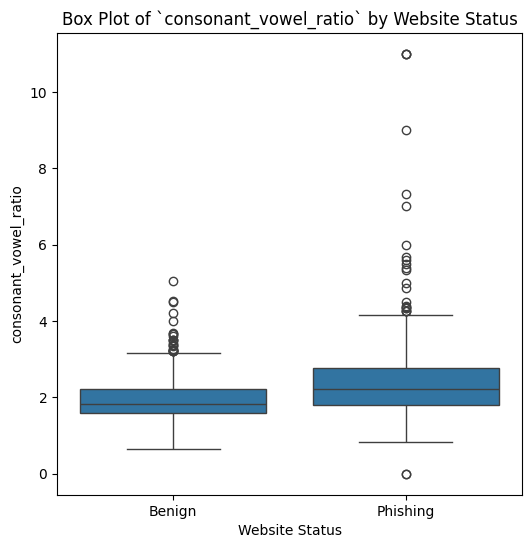

In [31]:
sampled_processed = calculateRatio(sampled_total)
summary_statistics = sampled_processed.groupby('type')['consonant_vowel_ratio'].describe()
print(summary_statistics)
displayBoxPlot('consonant_vowel_ratio', sampled_processed)

In conclusion, our analysis suggests a weak correlation between the consonant-to-vowel ratio and the likelihood of a website being a phishing attempt. While phishing websites tend to exhibit slightly higher ratios, this could also be attributed to longer URL lengths (as shown in our Exploratory Analysis), which naturally contain more consonants.  

In a world of evolving cyber threats, it's likely that threat actors are employing sophisticated obfuscation techniques, crafting more believable URLs that mimic natural language. This trend underscores the unfortunate reality of why phishing scams remain so successful.

---
### Feature 2: Evaluating _Strangeness_

To address the limitations of detecting 'natural English' in URLs, we propose a custom URL Strangeness Score (USS) that evaluates URLs based on the following characteristics:

1. **Character Diversity Index**: A measure that combines the variety of special characters in the URL. This can be an indicator of complexity and potential obfuscation attempts.
   - Components: `qty_hyphen_url`, `qty_underline_url`, `qty_slash_url`, `qty_questionmark_url`, `qty_equal_url`, `qty_at_url`, `qty_and_url`, `qty_exclamation_url`, `qty_space_url`, `qty_tilde_url`, `qty_comma_url`, `qty_plus_url`, `qty_asterisk_url`, `qty_hashtag_url`, `qty_dollar_url`, `qty_percent_url`

2. **Domain Complexity Index**: Focuses on the complexity within the domain part of the URL, which might indicate an attempt to mimic legitimate domain names.
   - Components: `qty_dot_domain`, `qty_hyphen_domain`, `qty_underline_domain`, `domain_length`, `qty_vowels_domain`

3. **Path Complexity Index**: Measures the complexity in the path, directory, and file structure of the URL, which can be used for obfuscation.
   - Components: `directory_length`, `qty_dot_directory`, `qty_hyphen_directory`, `qty_underline_directory`, `file_length`, `qty_dot_file`, `qty_hyphen_file`, `qty_underline_file`

4. **Parameter Complexity Index**: Assesses the complexity and potential misuse of URL parameters, often used in phishing to add credibility to the URL or to redirect.
   - Components: `params_length`, `qty_params`, `qty_equal_params`, `qty_and_params`

The USS can be computed as a weighted sum of the given attributes for each row. Each coloumn component within a row can be normalised based on the observed maximum value in that column.

E.g. CDI = qty_hyphen_url/max(qty_hyphen_url) + qty_underline_url/max(qty_underline_url) + ...

Weights are assigned based on their judged significance by our group.

##### Overall Formula:
```
USS = 15(CDI) + 35(DCI) + 20(PCI) + 30(PRCI)
```

Where:
- CDI = Character Diversity Index
- DCI = Domain Complexity Index
- PCI = Path Complexity Index
- PRCI = Parameter Complexity Index

In [22]:
cdi_list = [
    'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_questionmark_url', 'qty_equal_url', 
    'qty_at_url', 'qty_and_url', 'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url', 'qty_comma_url', 
    'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url', 'qty_dollar_url', 'qty_percent_url'
]

dci_list = [
    'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain', 'domain_length', 'qty_vowels_domain'
]

pci_list = [
    'directory_length', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 
    'file_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file'
]

prci_list = [
    'params_length', 'qty_params', 'qty_equal_params', 'qty_and_params'
]

total_list = [
    cdi_list, dci_list, pci_list, prci_list
]

def normalise_columns(df, columns):
    for column in columns:
        max_value = df[column].max()
        # To avoid division by zero, check if max_value is not zero
        if max_value != 0:
            df[column + '_norm'] = df[column] / max_value
        else:
            df[column + '_norm'] = 0
    return df

def calculate_index(df, columns):
    index_sum = df[[col + '_norm' for col in columns]].sum(axis=1)
    return index_sum

def clean_data(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x < 0 else x)
    return df

def displayBoxPlot(numerical_data, df):
    plt.figure(figsize=(6, 6))
    sb.boxplot(x='phishing', y=numerical_data, data=df)
    plt.title(f'Box Plot of `{numerical_data}` by Phishing Status')
    plt.xlabel('Phishing Status')
    plt.ylabel(numerical_data)
    plt.xticks([0, 1], ['Non-Phishing', 'Phishing'])
    plt.show()

          count       mean        std       min        25%        50%  \
phishing                                                                
0         500.0  22.851602   9.306994  6.163043  17.153673  20.643178   
1         500.0  36.628312  20.634203  8.072542  24.583779  32.486051   

                75%         max  
phishing                         
0         25.757309   87.025877  
1         42.536901  225.741290  


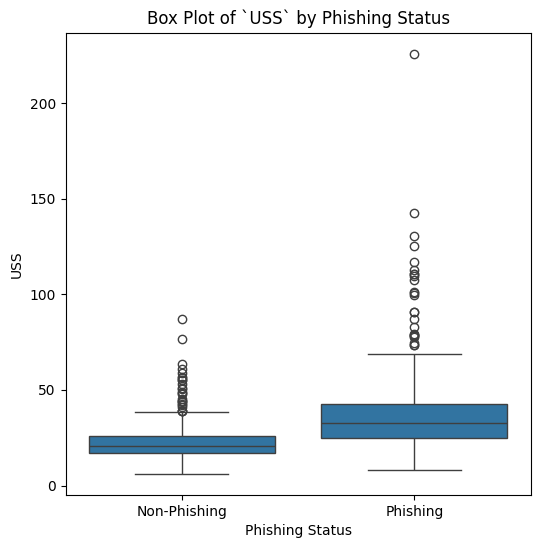

In [26]:
# USS Calculation

phishing_urls = url_information[(url_information['phishing'] == 1)]
benign_urls = url_information[(url_information['phishing'] == 0)]
sampled_phishing = phishing_urls.sample(n=500, replace=False, random_state=69)
sampled_benign = benign_urls.sample(n=500, replace=False, random_state=69)
sampled_total = pd.concat([sampled_phishing, sampled_benign])

all_features = sum(total_list, [])
sampled_total = clean_data(sampled_total, all_features)

for feature_list in total_list:
    sampled_total = normalise_columns(sampled_total, feature_list)

CDI = calculate_index(sampled_total, cdi_list)
DCI = calculate_index(sampled_total, dci_list)
PCI = calculate_index(sampled_total, pci_list)
PRCI = calculate_index(sampled_total, prci_list)

sampled_total['USS'] = 15 * CDI +  35 * DCI + 20 * PCI + 30 * PRCI

summary_statistics = sampled_total.groupby('phishing')['USS'].describe()
print(summary_statistics)
displayBoxPlot('USS', sampled_total)